In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import config
from dataset import OCRDataset
from model import OCRResNet18, OCRResNet50
import utils

In [3]:
selected_annotation_list, index_to_utf16 = utils.prepare_selected_annotation_from_dataset_indexes([0,  1,  2,  3,  4,
                                                                                                   5,  6,  10, 11, 12,
                                                                                                   14, 15, 16, 17, 18, 
                                                                                                   19, 20, 21, 22, 23, 
                                                                                                   24, 25, 26])
train_annotation_list, validation_annotation_list = train_test_split(selected_annotation_list,
                                                                     test_size=0.2,
                                                                     random_state=config.RANDOM_SEED)

In [4]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = OCRDataset(train_annotation_list, transform=tf)
validation_dataset = OCRDataset(validation_annotation_list, transform=tf)

batchsize = 16
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False)

In [27]:
def show_result(image, bboxes):
    # color_map = ['red', 'green', 'blue', 'yellow', 'purple', 'brown', 'pink', 'cyan', 'orange', 'black']
    nc = config.N_KINDS_OF_CHARACTERS
    color_map = [(i/nc, i/nc, i/nc) for i in range(nc)]
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    for char_index, bboxes_per_class in enumerate(bboxes):
        confidence, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        for idx, (mx, my, w, h) in enumerate(zip(min_x, min_y, width, height)):
            if idx == 0:
                rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
                                         fill=False, edgecolor=color_map[char_index])#, label=index_to_utf16[char_index])
            else:
                rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
                                         fill=False, edgecolor=color_map[char_index])       
            ax.add_patch(rect)
    plt.legend(bbox_to_anchor=(1.3, 1))
    image_for_show = np.transpose(image.numpy(), [1, 2, 0])*0.5 + 0.5
    plt.imshow(image_for_show)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = OCRResNet50(5*config.N_KINDS_OF_CHARACTERS, pretrained=True)
net = net.to(device)
params = torch.load('../../data/komonjo/logs/20190321_2/weight_500.pth')
net.load_state_dict(params)

In [29]:
train_images, train_labels = iter(train_loader).next()
validation_images, validation_labels = iter(validation_loader).next()

net.eval()
with torch.no_grad():
    train_preds = net(train_images.to(device))
    validation_preds = net(validation_images.to(device))

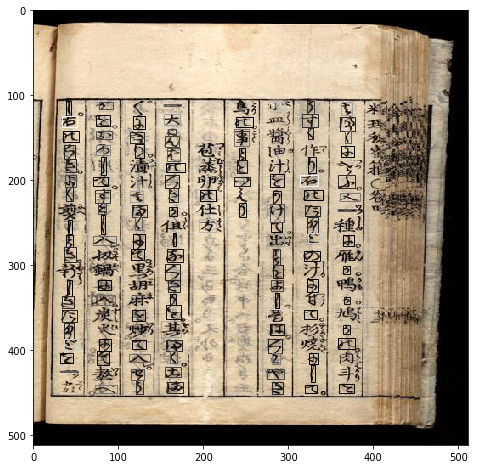

In [36]:
index = 6
image = train_images[index]
bboxes = train_dataset.label2bboxes(train_labels[index])
show_result(image, bboxes)

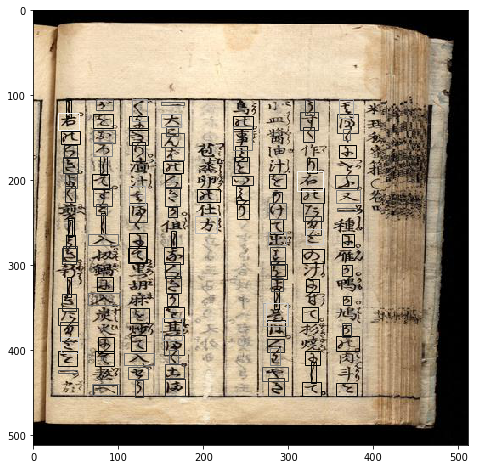

In [37]:
image = train_images[index]
bboxes = train_dataset.label2bboxes(train_preds[index].cpu(), confidence_border=0.95)
show_result(image, bboxes)

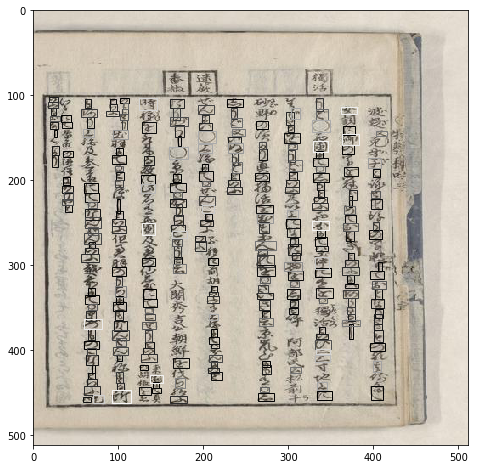

In [38]:
image = validation_images[index]
bboxes = validation_dataset.label2bboxes(validation_labels[index])
show_result(image, bboxes)

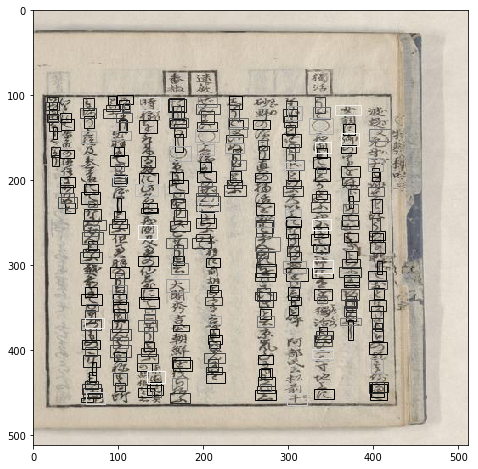

In [39]:
image = validation_images[index]
bboxes = validation_dataset.label2bboxes(validation_preds[index].cpu(), confidence_border=0.9)
show_result(image, bboxes)